In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset

In [68]:
class MYDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y
    
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_output):
        super().__init__()
        self.flatten = nn.Flatten()   # [b, c, h, w] -> [b, c*h*w]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_output)

    def forward(self, x):
        x = self.flatten(x)
        z1 = self.l1(x)
        a1 = F.relu(z1)
        x = self.l2(a1)
        return x


def learn(model, train_loader, val_loader, optimizer, loss_func, num_epochs, early_stopping=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    no_improve_count = 0
    early_stop = 5

    for epoch in range(num_epochs):

        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0


        for train_batch, data in enumerate(train_loader):

            X, y = data
            optimizer.zero_grad()

            # forward
            preds = model(X)
            loss = F.cross_entropy(preds, y)
            running_loss += loss.item()

            # backward
            loss.backward()

            # パラメータ更新
            optimizer.step()

            # validation
            with torch.no_grad():
                for val_batch, data in enumerate(val_loader):
                    X_val, y_val = data
                    preds_val = model(X_val)
                    val_loss = F.cross_entropy(preds_val, y_val)
                    running_val_loss += val_loss.item()
                    val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                    running_val_acc += val_accuracy.item()

            train_losses.append(running_loss/(train_batch + 1))
            val_losses.append(running_val_loss/(val_batch + 1))
            val_accuracies.append(running_val_acc/(val_batch + 1))
            print(f'epoch: {epoch+1}: train_loss:{train_losses[-1]}, val_loss:{running_val_loss/(val_batch + 1)}, val_acuraccy:{running_val_acc/(val_batch + 1)}')

            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count and no_improve_count >= early_stop:
                print('stopping early')
                break


    return train_losses, val_losses, val_accuracies

In [69]:
# データロード
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
images = images / (255. / 16.)   # 0-16 -> 0-255
images = images.astype(np.uint8)
# 学習データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# DatasetとDataLoaderの作成
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 32
train_mydataset = MYDataset(X_train, y_train, transform=transform)
val_mydataset = MYDataset(X_val, y_val, transform=transform)
train_myloader = DataLoader(train_mydataset, batch_size=batch_size, shuffle=True)
val_myloader = DataLoader(val_mydataset, batch_size=batch_size, shuffle=False)
early_stopping = 5

## Refactoring後の学習ループ
epochs = 100
learning_rate = 0.03
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
learn(model, train_myloader, val_myloader, opt, F.cross_entropy, epochs, early_stopping)

epoch: 1: train_loss:2.346662998199463, val_loss:2.3322680791219077, val_acuraccy:0.10416666666666667
epoch: 1: train_loss:2.323965311050415, val_loss:4.663248042265574, val_acuraccy:0.20833333333333334
epoch: 1: train_loss:2.328332265218099, val_loss:6.990994652112325, val_acuraccy:0.3125
epoch: 1: train_loss:2.331631064414978, val_loss:9.316917717456818, val_acuraccy:0.4088541666666667
epoch: 1: train_loss:2.3188130378723146, val_loss:11.644083460172018, val_acuraccy:0.5130208333333334
epoch: 1: train_loss:2.31836199760437, val_loss:13.970057229200998, val_acuraccy:0.6171875
stopping early
epoch: 2: train_loss:2.3314902782440186, val_loss:2.322183847427368, val_acuraccy:0.10416666666666667
epoch: 2: train_loss:2.3122187852859497, val_loss:4.644422094027202, val_acuraccy:0.20833333333333334
epoch: 2: train_loss:2.3170200188954673, val_loss:6.966571748256683, val_acuraccy:0.3125
epoch: 2: train_loss:2.301735520362854, val_loss:9.292587459087372, val_acuraccy:0.4088541666666667
epoch: 2

([2.346662998199463,
  2.323965311050415,
  2.328332265218099,
  2.331631064414978,
  2.3188130378723146,
  2.31836199760437,
  2.3314902782440186,
  2.3122187852859497,
  2.3170200188954673,
  2.301735520362854,
  2.3119726181030273,
  2.309801618258158,
  2.278630495071411,
  2.3275434970855713,
  2.2969489097595215,
  2.3374109268188477,
  2.3144220113754272,
  2.316940943400065,
  2.3195096254348755,
  2.316681385040283,
  2.314824938774109,
  2.3068737983703613,
  2.3026076555252075,
  2.3004511992136636,
  2.2981045246124268,
  2.295072650909424,
  2.2974379857381186,
  2.281217575073242,
  2.291964054107666,
  2.3192567825317383,
  2.2736456394195557,
  2.316148042678833,
  2.323068857192993,
  2.3158113956451416,
  2.315946578979492,
  2.324891686439514,
  2.3217879136403403,
  2.3161937594413757,
  2.3130289554595946,
  2.311664899190267,
  2.286052703857422,
  2.31450355052948,
  2.3097668488820395,
  2.306563973426819,
  2.3027220726013184,
  2.302462339401245,
  2.306459426

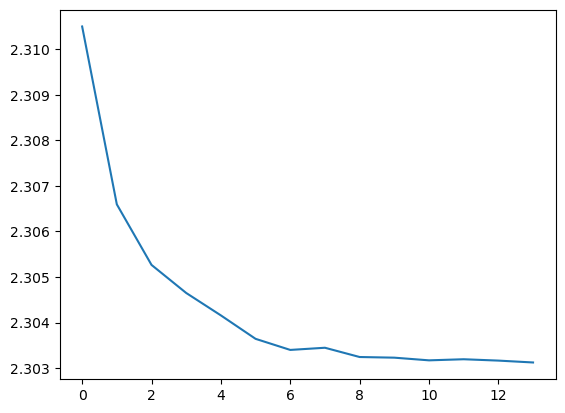

In [70]:
plt.plot(train_losses, label='train_loss')

### モデルオブジェクトの保存

In [71]:
loaded_model = torch.save(model, 'sample_model.pth')

In [72]:
loaded_model

### モデルパラメータの保存

In [73]:
params = model.state_dict()

In [74]:
another_model = MLP(64, 30, 10)

In [75]:
another_model.load_state_dict(params)

<All keys matched successfully>

In [76]:
another_model.l1.weight

Parameter containing:
tensor([[ 0.0506,  0.1056, -0.0886,  ..., -0.0413,  0.0196,  0.0088],
        [-0.0862, -0.0118,  0.1015,  ...,  0.1169, -0.0654, -0.0286],
        [ 0.0755, -0.0601, -0.0569,  ...,  0.0268, -0.0300, -0.0717],
        ...,
        [ 0.0723,  0.1170,  0.0233,  ...,  0.1085,  0.0122,  0.1290],
        [-0.0191, -0.1131, -0.0548,  ...,  0.0099, -0.1253, -0.0532],
        [ 0.0483,  0.0399, -0.0713,  ...,  0.0327,  0.1106,  0.0655]],
       requires_grad=True)

In [77]:
torch.save(model.state_dict(), 'sample_model_state_dict.pth')

In [78]:
another_model.load_state_dict(torch.load('sample_model_state_dict.pth'))

<All keys matched successfully>